# Predicting Bulldozer Prices using Machine Learning

How well can we predict the future sale price of a bulldozer, given the characteristics and sale prices of previously sold bulldozers?

The Data is obtained from a previous competition from Kaggle

https://www.kaggle.com/c/bluebook-for-bulldozers/data

The following excerpt describing the data is from the link provided above.

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.
The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).



The evaluation metric to be used is the RMSLE (root mean squrare log error) between the actual and predicted auction prices 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn


## Data Exploration

In [2]:
# Import training and validation data sets
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory = False)
# Take note of the warning: Columns 13, 39,40, and 41 have mixed data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

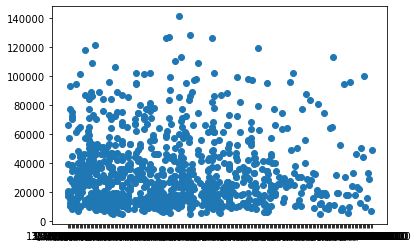

In [5]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

<AxesSubplot:ylabel='Frequency'>

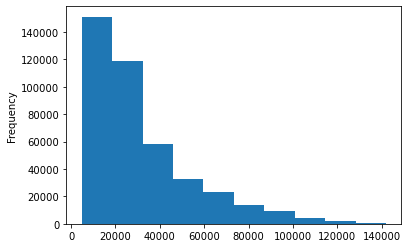

In [6]:
df.SalePrice.plot.hist()

### Parsing Dates

We want to enrich time and date component as much as possible by using the 'parse_dates' parameter

In [7]:
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', 
                 low_memory=False, 
                 parse_dates=['saledate'])

In [8]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

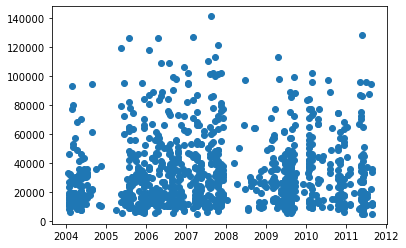

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [10]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [12]:
### Sort the data frame by sale date
df.sort_values(by = ['saledate'], inplace = True, ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

Now, we'll make a copy of the original data frame before we begin to manipulate the data

In [13]:
df_tmp = df.copy()

In [14]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Adding datetime parameter for saledate column

In [15]:
df_tmp['SaleYear'] = df_tmp.saledate.dt.year
df_tmp['SaleMonth']=df_tmp.saledate.dt.month
df_tmp['SaleDay']=df_tmp.saledate.dt.day
df_tmp['SaleDayOfWeek']=df_tmp.saledate.dt.dayofweek
df_tmp['SaleDayOfYear']=df_tmp.saledate.dt.dayofyear

In [16]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


With the above information, we dont need the saledate column anymore

In [17]:
df_tmp.drop('saledate', axis = 1, inplace = True)

Now we examine which states the Bulldozers were sold in

In [18]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Data Wrangling

We need to fill missing data as well as sconvert object tyoe data into numerical form

In [19]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [20]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Handling Categorical Data Types

One way we can handle object data types is by converting them into pandas categories.

In [21]:
# Finding Columns which contain strings
for labels, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[labels]=content.astype('category').cat.as_ordered()

In [22]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

Note that all columns with dtype object are now dtype category, where each category has been assigned a number

In [23]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [24]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

## Save preprocessed data

We will save our data at this point so that we need not run every single cell the next time we come back.

In [25]:
df_tmp.to_csv('data/train_tmp.csv', index = False)

In [26]:
# Import back the preprocessed data

df_tmp= pd.read_csv('data/train_tmp.csv', low_memory=False)

In [27]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## Filling Missing Values

First, we shall start with filling in the missing numeric values

In [28]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [29]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # we will also add a binary column (True or False) to tell us if data is missing or not
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Now we fill missing values with median value
            df_tmp[label] = content.fillna(content.median())

In [30]:
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

Now that our missing numeric data is filled, we shall turn our categorical data into numbers and then fill them

In [31]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add binary column just as above
        df_tmp[label + '_is_missing']= pd.isnull(content)
        # Turn categories into numbers and + 1
        df_tmp[label] = pd.Categorical(content).codes + 1 # since missing categorical values are indicated by -1

Before we continue with Modelling, lets check that there are no missing values first

In [32]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## Modelling

In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs = -1, random_state=42)
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

RandomForestRegressor(n_jobs=-1, random_state=42)

## Splitting data into Train and Validation Sets

* Training data set will be data from 2011 and before.
* Validation data set will be everything from 2012 onwards.

In [34]:
 df_tmp.SaleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: SaleYear, dtype: int64

## Note: We are spliting data after filling them with median values. This is WRONG. We should NEVER MIX TRANING AND VALIDATION DATA

In [35]:
# Split the data
df_val = df_tmp[df_tmp.SaleYear == 2012]
df_train = df_tmp[df_tmp.SaleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [36]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

Recall that the evaluation metric used is RMSLE, so we will have to build our own evaluation function.

In [37]:
from sklearn.metrics import mean_squared_log_error # we will have to modify this function
from sklearn.metrics import mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))
# We will also create an evaluation function using other criteria as well
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'training MAE': mean_absolute_error(y_train, train_preds),
              'valid MAE': mean_absolute_error(y_valid, val_preds),
              'training RMSLE': rmsle(y_train, train_preds),
              'valid RMSLE' : rmsle(y_valid, val_preds),
              'training R squared' : r2_score(y_train, train_preds),
              'valid R squared' : r2_score(y_valid, val_preds)
             }
    return scores

Now we will test our model on a subset so that we can tune our hyperparameters.

We do this since training our model on the entire training set, which we will eventually do, will take a significant amount of time.

In [38]:
len(X_train)

401125

In [39]:
# We will reduce the amount of training data by changing the max_samples parameter
# We will train the model on 10 000 samples only
model = RandomForestRegressor(n_jobs = -1, random_state=42, max_samples=10000)
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [40]:
show_scores(model)

{'training MAE': 5561.2988092240585,
 'valid MAE': 7177.26365505919,
 'training RMSLE': 0.257745378256977,
 'valid RMSLE': 0.29362638671089003,
 'training R squared': 0.8606658995199189,
 'valid R squared': 0.8320374995090507}

## Hyperparameter Tuning

Now we will use RandomizedSearchCV and GridSearchCV to look for the best Hyperparameters to use

In [41]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
rf_grid = {'n_estimators' : np.arange(10,100,10),
           'max_depth' : [None, 3 ,5 ,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf' : np.arange(2,20,2),
           'max_features' : [0.5,1,'sqrt', 'auto'],
           'max_samples' : [1000] # We still need this to reduce time between experiments
          }
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                              param_distributions=rf_grid,
                              n_iter = 2, # start low at first, some models may take hours
                              cv=5,
                              verbose = True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [1000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [42]:
rs_model.best_params_ # Note that only 2 random combinations of parameters were used

{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 8,
 'max_samples': 1000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [43]:
show_scores(rs_model) # Again, the terrible scores are because only 2 random combinatiosn were tried

{'training MAE': 10633.535115958446,
 'valid MAE': 12267.842271054553,
 'training RMSLE': 0.457001151193127,
 'valid RMSLE': 0.4736468505660263,
 'training R squared': 0.5601289175424158,
 'valid R squared': 0.5702876039354932}

In [44]:
# Say we found the best Hyperparameters


## Training model with the best Hyperparameter combination

In [45]:
# We will train our model on the full data set now
ideal_model = RandomForestRegressor(n_jobs=-1, random_state=42,
                                    n_estimators = 40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    max_samples=None)
ideal_model.fit(X_train,y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [46]:
show_scores(ideal_model) 

{'training MAE': 2953.8161137163484,
 'valid MAE': 5951.247761444453,
 'training RMSLE': 0.14469006962371858,
 'valid RMSLE': 0.24524163989538328,
 'training R squared': 0.9588145522577225,
 'valid R squared': 0.8818019502450094}

Note that up until the above cell, we have only been using the train and validation set. We have not used the model on the test set, which it the result that truly matters

## Making Predictions on Test Data

In [47]:
df_test=pd.read_csv('data/bluebook-for-bulldozers/Test.csv', low_memory=False, parse_dates = ['saledate'])

In [48]:
df_test.head() #The 'SalePrice' Column is missing

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Before predictions are made, the test data has to be preprocessed too

In [49]:
def preprocess_data(df):
    df['SaleYear'] = df.saledate.dt.year
    df['SaleMonth']=df.saledate.dt.month
    df['SaleDay']=df.saledate.dt.day
    df['SaleDayOfWeek']=df.saledate.dt.dayofweek
    df['SaleDayOfYear']=df.saledate.dt.dayofyear
    
    df.drop('saledate', axis = 1, inplace = True)
    
    #Turn string dtype into categories
    for labels, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[labels]=content.astype('category').cat.as_ordered()
    
    #Fill missing numeric data with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # we will also add a binary column (True or False) to tell us if data is missing or not
                df[label+'_is_missing'] = pd.isnull(content)
                # Now we fill missing values with median value
                df[label] = content.fillna(content.median())
     
    # Fill missing categorical data and convert to numbers
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            #Add binary column just as above
            df[label + '_is_missing']= pd.isnull(content)
            # Turn categories into numbers and + 1
            df[label] = pd.Categorical(content).codes + 1 # since missing categorical values are indicated by -1
    return df

In [50]:
df_test = preprocess_data(df_test)

In [51]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(45), float64(1), int16(2), int64(11), int8(42)
memory usage: 2.2 MB


Note that there are different numbers of columns in the training data and the test data

In [52]:
# Finding the missing column using sets
set(X_train.columns) - set(df_test.columns)


{'auctioneerID_is_missing'}

In [53]:
# adding a column named 'auctioneerID_is_missing' to df_test and have all its values be False
df_test['auctioneerID_is_missing'] = False
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 102 entries, SalesID to auctioneerID_is_missing
dtypes: bool(46), float64(1), int16(2), int64(11), int8(42)
memory usage: 2.2 MB


Now we can make predictions

In [54]:
test_preds = ideal_model.predict(df_test)

In [55]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

For the Kaggle Competition, the data needs to be in a dataframe format

In [56]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice']=test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [57]:
# Exporting to 
df_preds.to_csv('data/test_predictions.csv', index=False)

## Feature Importance

In [58]:
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [59]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features':columns, 'feature_importances':importances})
          .sort_values('feature_importances', ascending=False).reset_index(drop=True))
    #PLot the Data Frame
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Importances')
    ax.invert_yaxis()

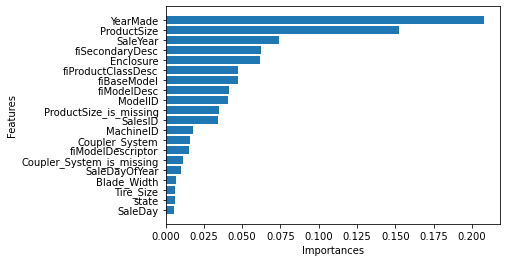

In [60]:
plot_features(X_train.columns, ideal_model.feature_importances_)